<a href="https://colab.research.google.com/github/akrawat912/Deep-Learning/blob/master/fruits_360_transfer_learning_with_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fruits-360, famous image dataset for classification in field of deep learning to get hands dirty with. We will use kaggle API to fetch dataset from kaggle. Also, using VGG16 for transfer learning and some of our custom layers.
keras's image preprocessing class ImageDataGenerator.
Then finally, after getting best accuracy (hope so), will predict for some fruits.

In [0]:
# for uploading kaggle.json file
# it has kaggle user_name and unique key to all kaggle users for interacting with kaggle
from google.colab import files
files.upload()

In [0]:
# install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle, moving .json there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
# changing permission
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#download dataset from kaggle 
!kaggle datasets download  -d moltean/fruits

100% 729M/732M [00:38<00:00, 18.7MB/s]
100% 732M/732M [00:38<00:00, 20.1MB/s]


In [0]:
# create new dir to extract .zip
!mkdir fruits
# unzipping into fruits directory
!unzip fruits.zip -d fruits

Streaming output truncated to the last 5000 lines.
  inflating: fruits/fruits-360/Training/Tangelo/r_16_100.jpg  
  inflating: fruits/fruits-360/Training/Tangelo/r_17_100.jpg  
  inflating: fruits/fruits-360/Training/Tangelo/r_181_100.jpg  
  inflating: fruits/fruits-360/Training/Tangelo/r_182_100.jpg  
  inflating: fruits/fruits-360/Training/Tangelo/r_183_100.jpg  
  inflating: fruits/fruits-360/Training/Tangelo/r_184_100.jpg  
  inflating: fruits/fruits-360/Training/Tangelo/r_185_100.jpg  
  inflating: fruits/fruits-360/Training/Tangelo/r_186_100.jpg  
  inflating: fruits/fruits-360/Training/Tangelo/r_187_100.jpg  
  inflating: fruits/fruits-360/Training/Tangelo/r_188_100.jpg  
  inflating: fruits/fruits-360/Training/Tangelo/r_189_100.jpg  
  inflating: fruits/fruits-360/Training/Tangelo/r_18_100.jpg  
  inflating: fruits/fruits-360/Training/Tangelo/r_190_100.jpg  
  inflating: fruits/fruits-360/Training/Tangelo/r_191_100.jpg  
  inflating: fruits/fruits-360/Training/Tangelo/r_192_10

In [0]:
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l2
from keras.layers import Dense, Flatten, Dropout, MaxPool2D, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pickle
import os

In [0]:
# directory structure
glob('fruits/fruits-360/*')

['fruits/fruits-360/Test',
 'fruits/fruits-360/LICENSE',
 'fruits/fruits-360/readme.md',
 'fruits/fruits-360/test-multiple_fruits',
 'fruits/fruits-360/papers',
 'fruits/fruits-360/Training']

In [0]:
# re-size all the images to 224*224*3, vgg16 was originally trained on 224*224 image size.
IMAGE_SHAPE = (128, 128, 3)
train_path = 'fruits/fruits-360/Training'
val_path = 'fruits/fruits-360/Test'
num_classes= len(glob(train_path+'/*'))
batch_size = 32
epochs = 10
CLASS_NAMES=[i.split('/')[-1] for i in glob(train_path+'/*')]

Data Augmentation for Image Generator

In [0]:
 # To expand the training dataset in order to improve the performance and ability of the model to generalize.
img_datagen_train = ImageDataGenerator(rescale = 1./255,  shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, 
                                   horizontal_flip = True, validation_split=0.2) 
img_datagen_test = ImageDataGenerator(rescale = 1./255)

In [0]:
# flow_from_directory takes the path to a directory & generates batches of augmented data.
train_gen = img_datagen_train.flow_from_directory(directory=train_path,
                                            target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                            batch_size = batch_size,
                                            shuffle=True,
                                            classes=CLASS_NAMES,
                                            class_mode = 'categorical'
                                            )
test_gen = img_datagen_test.flow_from_directory(directory=val_path,
                                            target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                            batch_size = batch_size,
                                            shuffle=True,
                                            classes=CLASS_NAMES,
                                            class_mode = 'categorical'
                                            )

Found 60486 images belonging to 120 classes.
Found 20618 images belonging to 120 classes.


Modelling

In [0]:
# model creation
def create_model(input_shape):
    # load VGG16, with popping out original o/p layer and weights of imagenet
    vgg = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    # freeze all the weights of the model except last 2 layers
    for layer in vgg.layers:
      layer.trainable=False
    x=vgg.output
    # cutom layers
    x=Flatten()(x)
    x=Dropout(0.3)(x)
    x=Dense(units=512, activation='relu', bias_regularizer=l2(0.001))(x)
    outputs=Dense(len(CLASS_NAMES), activation='softmax')(x)
    model=Model(inputs=vgg.input, outputs=outputs)
    model.summary()
    # training the model using adam optimizer
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [0]:
model=create_model(input_shape=IMAGE_SHAPE)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [0]:
# steps_per_epoch is batches of samples to train. It is used to define how many batches of samples to use in one epoch.
# usually ratio of total samples in train geneerator and batch size
training_steps_per_epoch = np.ceil(train_gen.samples / batch_size)
# usually ratio of total samples in validation geneerator and batch size
validation_steps_per_epoch = np.ceil(test_gen.samples / batch_size)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# saving checkpoints to gdrive
"""outputFolder = '/content/gdrive/My Drive/Colab Notebooks/fruits 360/output1'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+'/model-{epoch:02d}-{val_accuracy:.2f}.h5'"""

In [0]:
#ckpt = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=False, save_weights_only=False)
early_stopping= EarlyStopping(monitor='val_loss', patience=3)

In [0]:
# fit the model
r = model.fit_generator(train_gen, validation_data=test_gen, epochs=epochs,  steps_per_epoch=training_steps_per_epoch, 
                        validation_steps=validation_steps_per_epoch, callbacks=[early_stopping])

Epoch 1/10
1891/1891 [==============================] - 261s 138ms/step - loss: 1.0360 - accuracy: 0.7245 - val_loss: 0.2981 - val_accuracy: 0.8905
Epoch 2/10
1891/1891 [==============================] - 252s 133ms/step - loss: 0.3560 - accuracy: 0.8850 - val_loss: 0.7320 - val_accuracy: 0.8977
Epoch 3/10
1891/1891 [==============================] - 252s 133ms/step - loss: 0.2969 - accuracy: 0.9010 - val_loss: 0.0465 - val_accuracy: 0.9225
Epoch 4/10
1891/1891 [==============================] - 252s 133ms/step - loss: 0.2666 - accuracy: 0.9130 - val_loss: 0.0887 - val_accuracy: 0.9372
Epoch 5/10
1891/1891 [==============================] - 253s 134ms/step - loss: 0.2470 - accuracy: 0.9190 - val_loss: 0.2786 - val_accuracy: 0.9271
Epoch 6/10
1891/1891 [==============================] - 253s 134ms/step - loss: 0.2409 - accuracy: 0.9238 - val_loss: 0.1206 - val_accuracy: 0.9247


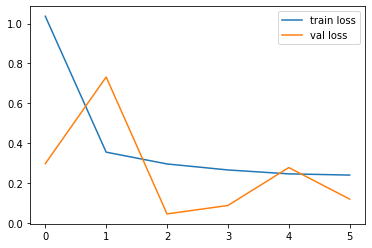

In [0]:
# loss plot
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

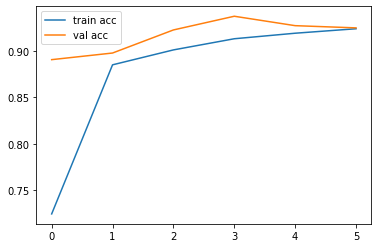

In [0]:
# accuracy plot
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

# Prediction

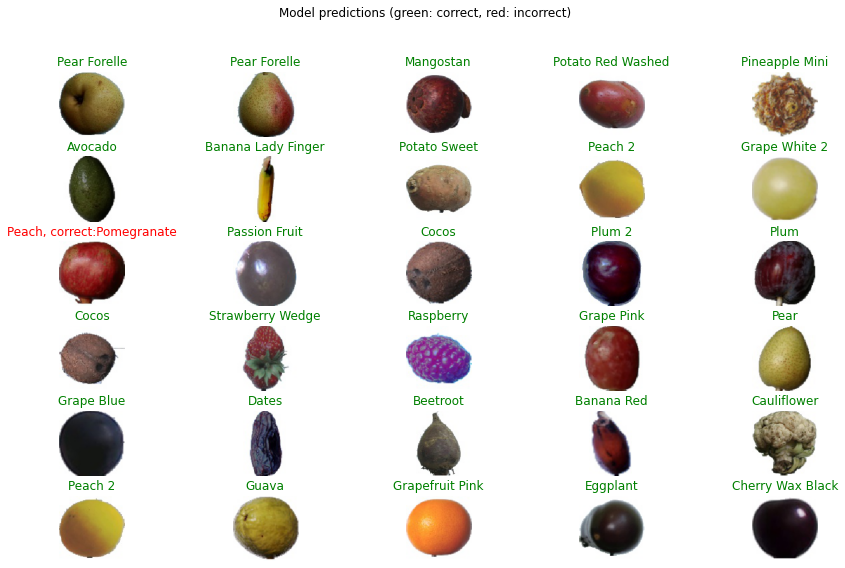

In [0]:
# get a random batch of images
image_batch, label_batch = next(iter(test_gen))
# turn the original labels into human-readable text
label_batch = [CLASS_NAMES[np.argmax(label_batch[i])] for i in range(batch_size)]
# predict the images on the model
predicted_class_names = model.predict(image_batch) 
predicted_ids = [np.argmax(predicted_class_names[i]) for i in range(batch_size)]
# turn the predicted vectors to human readable labels
predicted_class_names = np.array([CLASS_NAMES[id] for id in predicted_ids])
# some nice plotting
plt.figure(figsize=(15,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_class_names[n] == label_batch[n]:
        color = "green"
        title = predicted_class_names[n].title()
    else:
        color = "red"
        title = f"{predicted_class_names[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.show()

In [0]:
# model prediction looks pretty good, among 30 prediction our model mostly predict 20+ accurate classes

In [0]:
model.evaluate_generator(test_gen)
# loss and accuracy on test_gen

[0.03264572471380234, 0.9247259497642517]

In [0]:
# saving model to gdrive
save_filepath='/content/gdrive/My Drive/Colab Notebooks/fruits 360/'

In [0]:
with open(save_filepath+'fruits_trained_model_pickle', 'wb') as f:
  pickle.dump(model, f)
  f.close()
# save classes names
"""with open(save_filepath+'CLASS_NAMES', 'wb') as f:
  pickle.dump(CLASS_NAMES, f)
  f.close()"""

"with open(save_filepath+'CLASS_NAMES', 'wb') as f:\n  pickle.dump(CLASS_NAMES, f)\n  f.close()"

In [0]:
# load saved model
with open(save_filepath+'fruits_trained_model_pickle', 'rb') as f:
  model=pickle.load(f)
  f.close()